<a href="https://colab.research.google.com/github/iamviji/project/blob/master/EncoderModulatorSplitArch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 196 (delta 82), reused 18 (delta 3), pack-reused 0
Receiving objects: 100% (196/196), 18.00 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (82/82), done.
project  sample_data
EncoderModulatorSplitArch.ipynb  MainModelKerasOneHot.ipynb
EncoderOutputExperiment.ipynb	 MainModelModCoding.ipynb
End2End8PSK.ipynb		 MainModelOneHotMethod.ipynb
End2EndOneHotQPSK.ipynb		 MainModelOneHotMethodSoftMax.ipynb
End2EndQPSK.ipynb		 MainModelWithSingleBERTraining.ipynb
End2EndQPSKRegularized.ipynb	 README.md
MainModel.ipynb			 util.py
MainModelKeras.ipynb
     |████████████████████████████████| 1.1MB 3.2MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=06d1358a0a9ddd3709a46a3f857897afda44ed1d7df95ce323b3e8c8e2589908
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6

In [3]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 1 ... 1 1 0]
 [0 1 0 ... 0 1 1]
 [1 0 1 ... 0 1 0]
 ...
 [0 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [39]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.89s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.54s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.83s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 17.34s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.92s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.52s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.99s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 14.77s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.21s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.24s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.46s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.68s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 11.59s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.08s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.12s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.41s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.63s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.24s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.38s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.58s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.98s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.33s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 13.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.97s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.99s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.98s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.90s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 9.83s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.93s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.86s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [9]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.62s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.13s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.57s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.18s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.51s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.58s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.00s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.23s
SNR: 0.500:
 -> BER: 0.50
 -> Total Time: 13.13s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.94s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.05s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.16s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 10.14s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.75s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.58s
SNR: 1.500 - Iter: 750 - Last 250.0 it

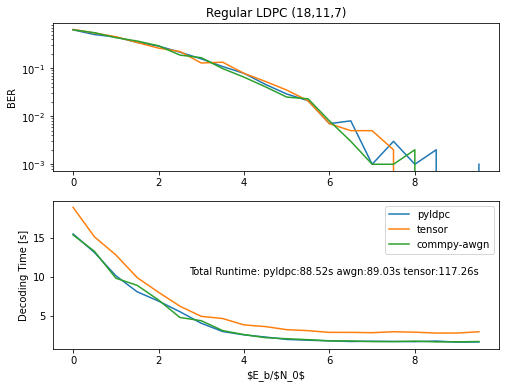

In [10]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [11]:
#18/9 = 2 bit per symbol => QPSK
num_of_channel = 9 
input_message_length = 11
encoder_output_length = 18

In [152]:
# Define Model 

# input_message_length is initialized by ldpc encoder

print ("input_message_length=", input_message_length)
print ("num_of_channel=", num_of_channel)
print ("encoder_output_length=", encoder_output_length)

num_of_hidden_layer_node = encoder_output_length

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_channel_x")
input_modulator_x = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_modulator_x")
input_dmodulator_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_dmodulator_x")
input_decoder_x = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_decoder_x")
input_encoder_out_ex = tf.placeholder("float32", [None, encoder_output_length], name="input_encoder_out_ex")
#input_decoder_in_ex = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_encoder_out_ex")
weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_of_hidden_layer_node], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_channel * 2], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_channel * 2, num_of_hidden_layer_node], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_hidden_layer_node], -1, 1), name="decoder_l2_weights"),
  "decoder_l3" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, input_message_length], -1, 1), name="decoder_l3_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_channel * 2], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l2_bias"),
  "decoder_l3" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l3_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  return layer_2


def dl_modulator (x):
  layer_3 =  x / tf.sqrt(tf.reduce_mean(tf.square(x)))
  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_2), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_dmodulator (x):
  layer_1 = (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  return layer_1

def dl_decoder (x):
  layer_2 = tf.nn.tanh (tf.matmul(x, weights['decoder_l2']) + biases['decoder_l2'])
  layer_3 = tf.nn.sigmoid(tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  #layer_3 = tf.nn.sigmoid (tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  return layer_3

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_modulator_output = dl_modulator (dl_encoder_output)
channel_output = awgn_layer(dl_modulator_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_dmodulator_output = dl_dmodulator (channel_output)
dl_decoder_output = dl_decoder (dl_dmodulator_output)

dl_modulator_only_output = dl_modulator(input_modulator_x)
dl_dmodulator_only_output = dl_dmodulator (input_dmodulator_x)
dl_decoder_only_output = dl_decoder(input_decoder_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + 1/2 * (tf.reduce_mean((tf.square(input_encoder_out_ex*input_encoder_out_ex - dl_encoder_output*dl_encoder_output))) + tf.reduce_mean((tf.square(input_encoder_out_ex*input_encoder_out_ex - dl_dmodulator_output*dl_dmodulator_output))))

#loss1 = tf.losses.sigmoid_cross_entropy(multi_class_labels=input_message_x,logits=dl_decoder_output)
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 11
num_of_channel= 9
encoder_output_length= 18


In [13]:
awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

In [14]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 0 0 ... 1 0 1]
 [0 1 1 ... 1 1 0]
 [0 1 0 ... 0 1 0]
 ...
 [1 1 1 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 [1 1 1 ... 1 0 0]]
10000


In [153]:
class GetOutOfLoop( Exception ):
    pass

batch_size = 400


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 100
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = .001
i = 0
opt = rms_optimizer
regularizer_const = numpy.ones((batch_size,encoder_output_length), dtype=int)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE*2)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma) 
      #if (snr < 6): opt = rms_optimizer1
      #else : opt = rms_optimizer 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
          x_train_batch_float = x_train_batch.astype("float32")
          _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate, input_encoder_out_ex:regularizer_const})
          if (l < 0.8): lrate = 0.0001
          if (l < 0.5): lrate = 0.00001
          if (l < 0.3): lrate = 0.0000001
          if (l < 0.1): lrate = 0.00000001
          if (l < 0.07): lrate = 0.000000005
          if j % display_step == 0:
            i = i + 1
            print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))
          #if (l < 0.005): raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

batch_size: 400 num_of_batcches: 25.0
Training for SNR= 0.0  sigma= 1.0
Step 50: Minibatch Loss: 375.541504
Step 100: Minibatch Loss: 230.373657
Step 150: Minibatch Loss: 171.357986
Step 200: Minibatch Loss: 118.141434
Step 250: Minibatch Loss: 90.569893
Step 300: Minibatch Loss: 78.201096
Step 350: Minibatch Loss: 65.099472
Step 400: Minibatch Loss: 59.398590
Step 450: Minibatch Loss: 52.440235
Step 500: Minibatch Loss: 43.331341
Step 550: Minibatch Loss: 39.677372
Step 600: Minibatch Loss: 33.680054
Step 650: Minibatch Loss: 34.300587
Step 700: Minibatch Loss: 32.588177
Step 750: Minibatch Loss: 30.983479
Step 800: Minibatch Loss: 26.401640
Step 850: Minibatch Loss: 25.590868
Step 900: Minibatch Loss: 22.468758
Step 950: Minibatch Loss: 23.456522
Step 1000: Minibatch Loss: 21.488087
Step 1050: Minibatch Loss: 19.009060
Step 1100: Minibatch Loss: 19.027590
Step 1150: Minibatch Loss: 18.768326
Step 1200: Minibatch Loss: 16.227839
Step 1250: Minibatch Loss: 14.564102
Step 1300: Minibatc

In [117]:
#a = [[1,2],[3,4]]
#x=a/numpy.sqrt(numpy.sum(numpy.square(a),axis=1).reshape([2,1]))
#print (x)
#print (1/numpy.sqrt(5))
#print (x[0][0]**2+x[0][1]**2)

#input_channel_x = tf.placeholder("float32", [None, 2], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x

#ans=train_sess.run ([l], feed_dict={input_channel_x:a})
#print (ans)

#print (ans[0][0]**2+ans[0][1]**2)

In [154]:
import matplotlib.pyplot as plt
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

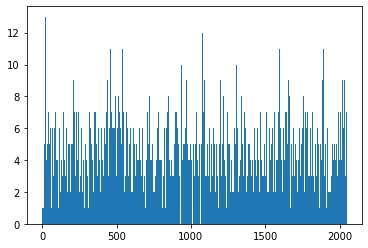

In [155]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

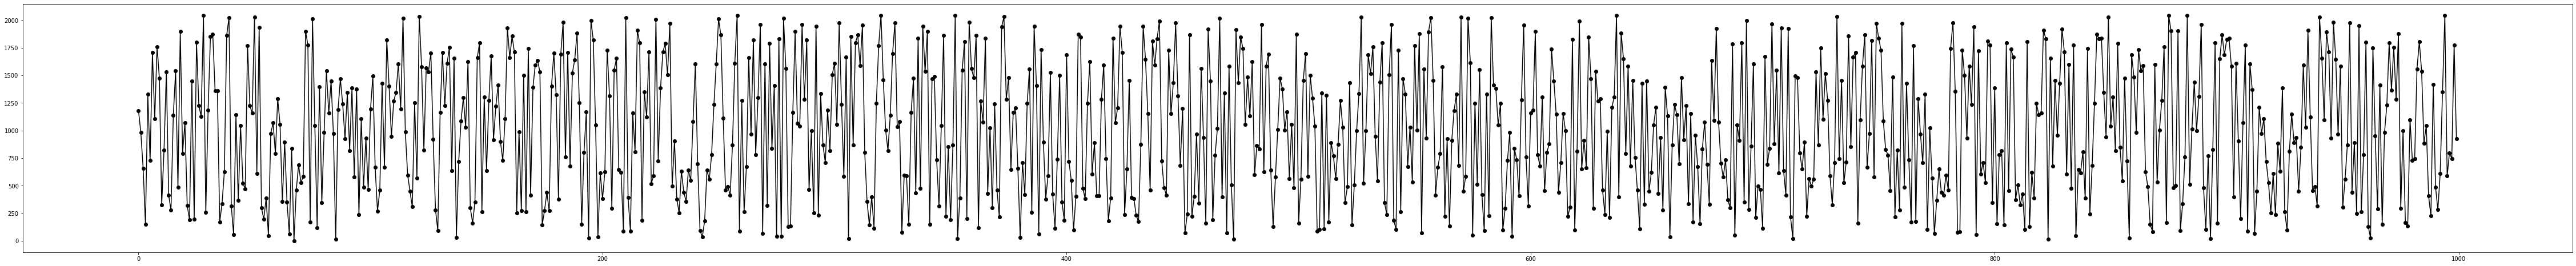

In [156]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [157]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 10
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
modulator_out = []
data_category = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    data_category.append (training_input_message_decimal [i:i+1][0])
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message[0]})    
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    channel_out.append(awgn_channel_output_message[0])    
    #print (awgn_channel_output_message[0])
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    modulator_out.append(quntized_demodule_out[0][0])
    #print(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out[0]})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.72s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.17s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.61s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.04s
SNR: 0.000:
 -> BER: 0.88
 -> Total Time: 5.54s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.44s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.89s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.78s
SNR: 0.500:
 -> BER: 0.85
 -> Total Time: 4.45s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.46s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.95s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.45s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.92s
SNR: 1.000:
 -> BER: 0.84
 -> Total Time: 4.78s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.48s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.93s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [121]:
#print (channel_in[-1])
#channel_in.append (-1*numpy.ones((CHANEL_SIZE), dtype=int))
#channel_in.append (numpy.ones((CHANEL_SIZE), dtype=int))
#print (-1*numpy.ones((1,CHANEL_SIZE), dtype=int))
#print (channel_in[-1])

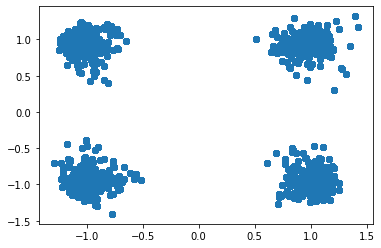

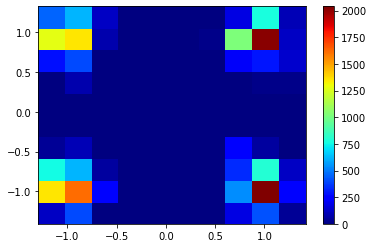

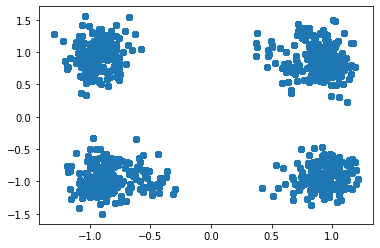

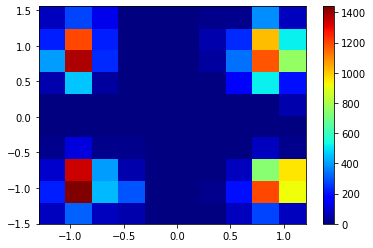

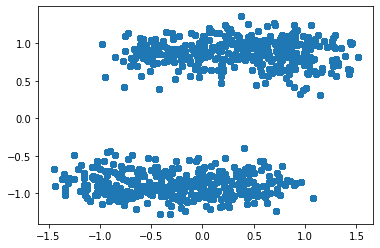

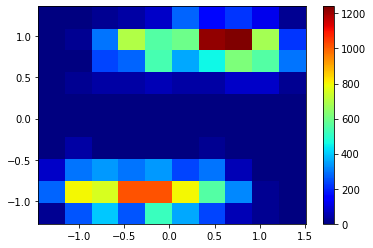

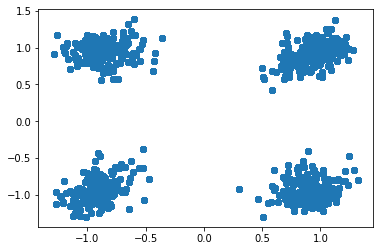

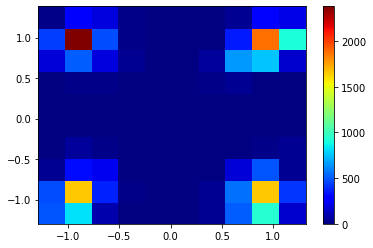

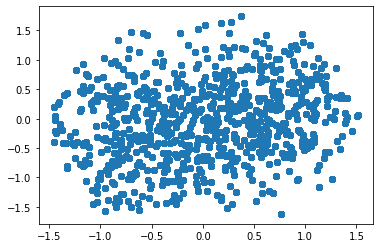

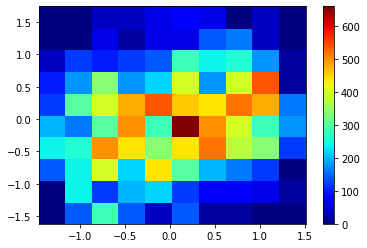

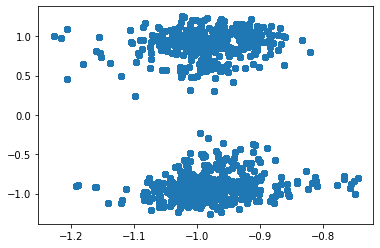

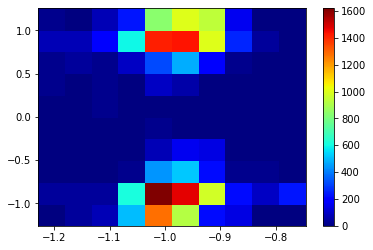

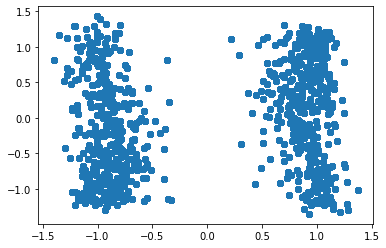

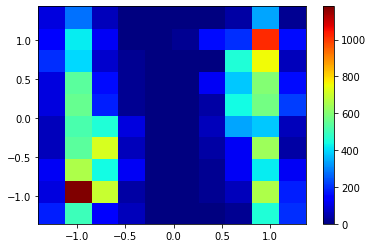

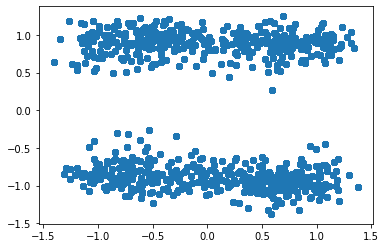

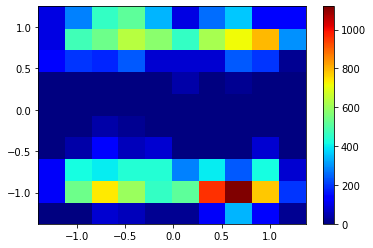

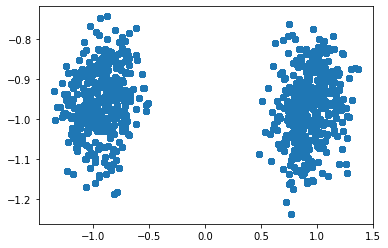

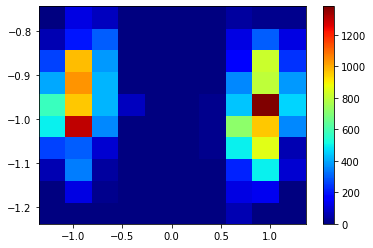

In [158]:
from IPython.core.display import display, HTML

#@title Default title text
channel_in_array = numpy.transpose(channel_in)
#channel_in_array = numpy.transpose(channel_in_array)
#print (channel_in_array)
import matplotlib.pyplot as plt
#data_category.append(0)
#data_category.append(0)

from IPython.display import HTML
display(HTML('''
<style>
  pre {
      white-space: normal;
  }
</style>
'''))
for i in range (int(CHANEL_SIZE/2)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

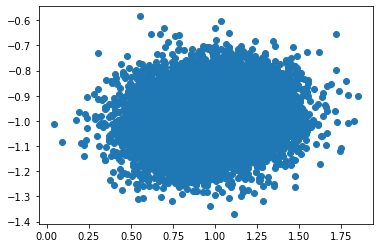

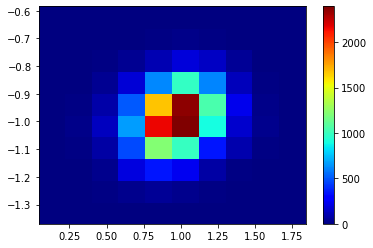

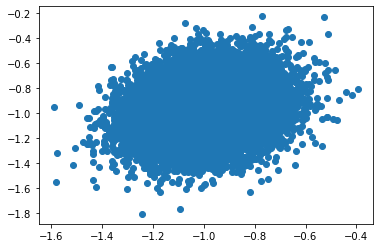

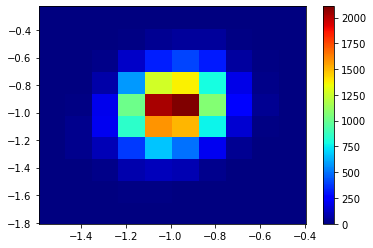

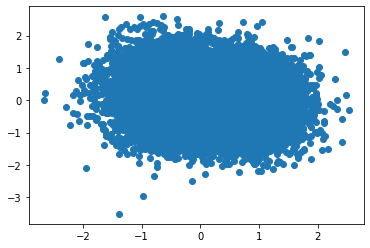

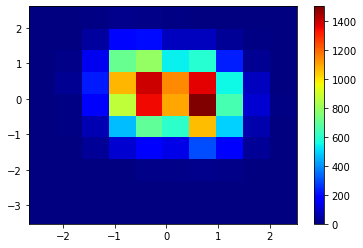

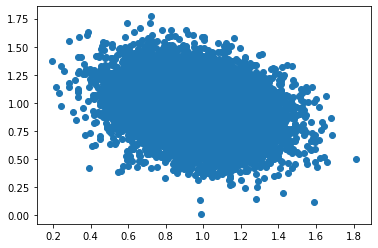

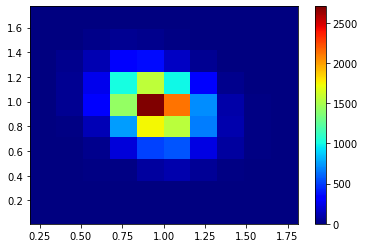

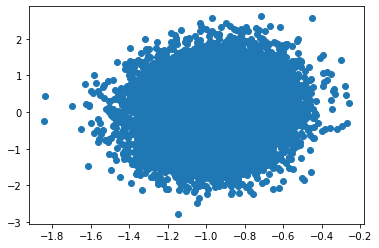

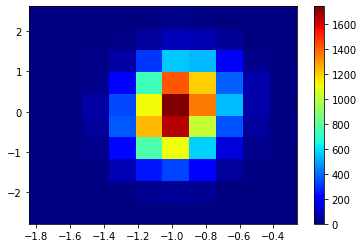

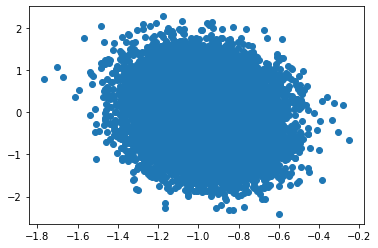

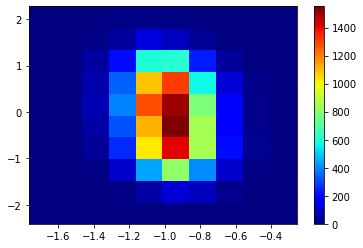

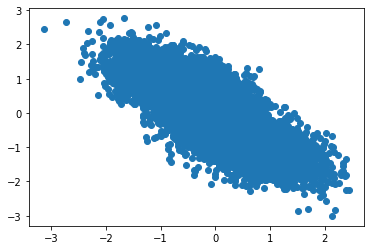

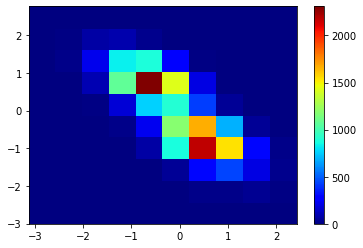

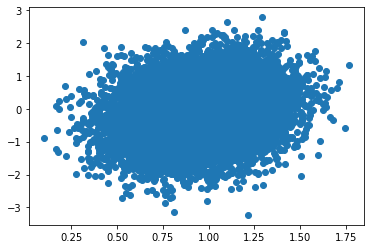

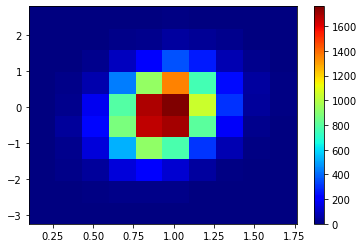

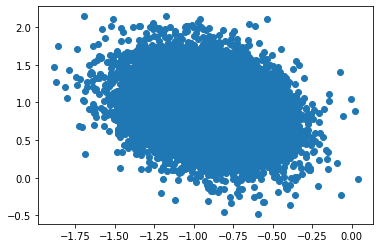

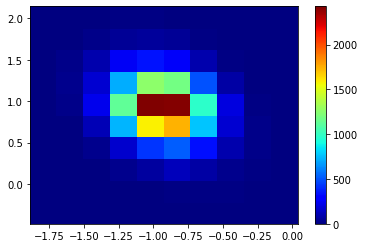

In [159]:

from IPython.core.display import display, HTML

#@title Default title text
modulator_in_array = numpy.transpose(modulator_out)
#channel_in_array = numpy.transpose(channel_in_array)
#print (channel_in_array)
import matplotlib.pyplot as plt
#data_category.append(0)
#data_category.append(0)

from IPython.display import HTML
display(HTML('''
<style>
  pre {
      white-space: normal;
  }
</style>
'''))
for i in range (int(CHANEL_SIZE/2)):
  plt.scatter(modulator_in_array[i*2], modulator_in_array[i*2+1])
  plt.show()
  plt.hist2d(modulator_in_array[i*2], modulator_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

[ 0.99250627  0.8867637  -0.9736565  ...  1.0323124  -0.81449336
  1.0507894 ]


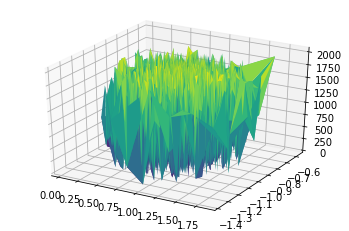

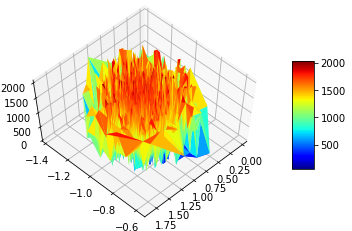

In [160]:
import pandas as pd
import seaborn
print (channel_in_array[0])
df = pd.DataFrame({'X':modulator_in_array[0],'Y':modulator_in_array[1],'value':data_category})

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['X'], df['Y'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

fig = plt.figure()

ax = fig.gca(projection='3d')
ax.view_init(60, 45)
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['X'], df['Y'], df['value'], cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()



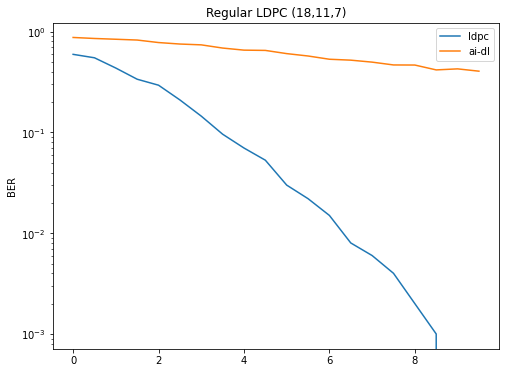

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [170]:
ch1_x = []
ch1_y = []
ch2_x = []
ch2_y = []
ch3_x = []
ch3_y = []
for c in channel_in:
  ch1_x.append (c[0])
  ch1_y.append (c[1])
  ch2_x.append (c[2])
  ch2_y.append (c[3])
  ch3_x.append (c[4])
  ch3_y.append (c[5])


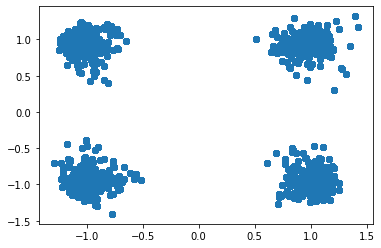

In [171]:
import matplotlib.pyplot as plt


plt.scatter(ch1_x, ch1_y)

plt.show()

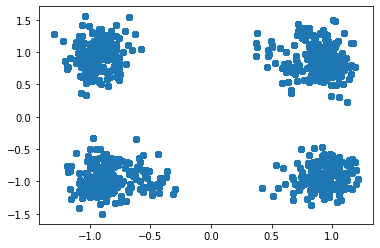

In [172]:
import matplotlib.pyplot as plt


plt.scatter(ch2_x, ch2_y)

plt.show()

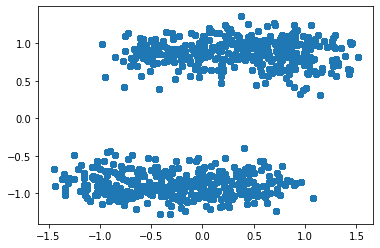

In [173]:

plt.scatter(ch3_x, ch3_y)

plt.show()

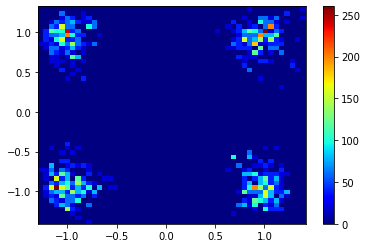

In [174]:
import matplotlib.pyplot as plt

plt.hist2d(ch1_x, ch1_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

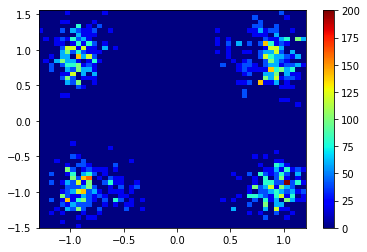

In [175]:
import matplotlib.pyplot as plt

plt.hist2d(ch2_x, ch2_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [176]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn

channel_in_embedded = TSNE(n_components=2).fit_transform(channel_in)

tsne_df = pd.DataFrame({'X':channel_in_embedded[:,0],
                        'Y':channel_in_embedded[:,1],
                        'value':data_category})

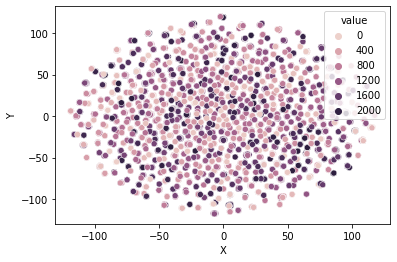

In [177]:
#seaborn.scatterplot(channel_in_embedded[:,0], channel_in_embedded[:,1],hue=data_category, legend='full', palette=['purple','red','orange','brown','blue','dodgerblue','green','lightgreen','darkcyan', 'black'])
#print (data_category)
palette = seaborn.color_palette("bright", 2**input_message_length)

seaborn.scatterplot(x="X", y="Y", hue="value",  data=tsne_df)


In [178]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn

channel_out_embedded = TSNE(n_components=2).fit_transform(channel_out)

out_tsne_df = pd.DataFrame({'X':channel_out_embedded[:,0],
                        'Y':channel_out_embedded[:,1],
                        'value':data_category})

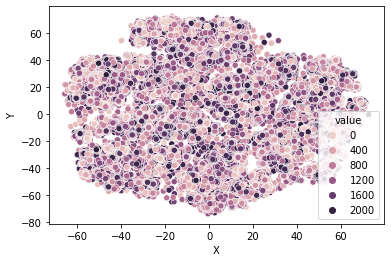

In [179]:
seaborn.scatterplot(x="X", y="Y", hue="value",  data=out_tsne_df)


In [162]:
# Here I am using trained model
# Encodec can be quantized but not modulator output
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.round(encoded_message[0])
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    quntized_demodule_out = quntized_demodule_out[0]
    #quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.49s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.98s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.49s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.99s
SNR: 0.000:
 -> BER: 0.88
 -> Total Time: 4.96s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.51s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.50s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.00s
SNR: 0.500:
 -> BER: 0.87
 -> Total Time: 5.03s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.49s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.96s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.45s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.94s
SNR: 1.000:
 -> BER: 0.86
 -> Total Time: 4.84s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.55s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.00s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

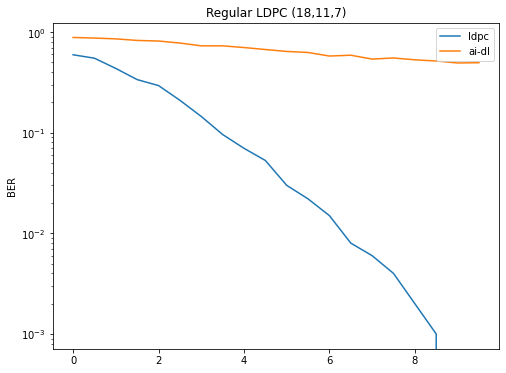

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [164]:
# Here I am using trained model
# Encodec can be quantized but not modulator output
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.round(encoded_message[0])
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    #quntized_demodule_out = quntized_demodule_out[0]
    quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.45s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.56s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.02s
SNR: 0.000:
 -> BER: 0.97
 -> Total Time: 5.03s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.48s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.95s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.48s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.06s
SNR: 0.500:
 -> BER: 0.98
 -> Total Time: 4.97s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.52s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.00s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.49s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.03s
SNR: 1.000:
 -> BER: 0.97
 -> Total Time: 5.03s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.50s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.98s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

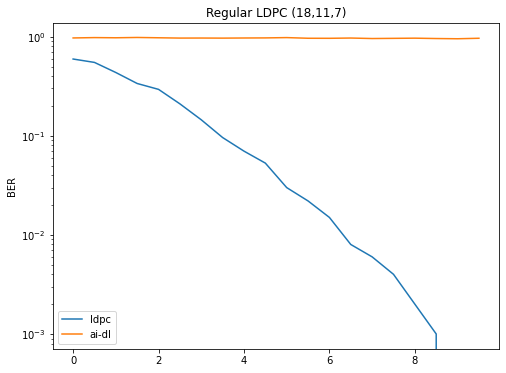

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [167]:
testing_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


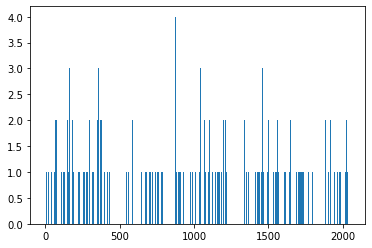

In [126]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
testing_input_message_decimal = row_bits2int(testing_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(testing_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(testing_input_message_decimal, bins = x_axis) 
plt.show()

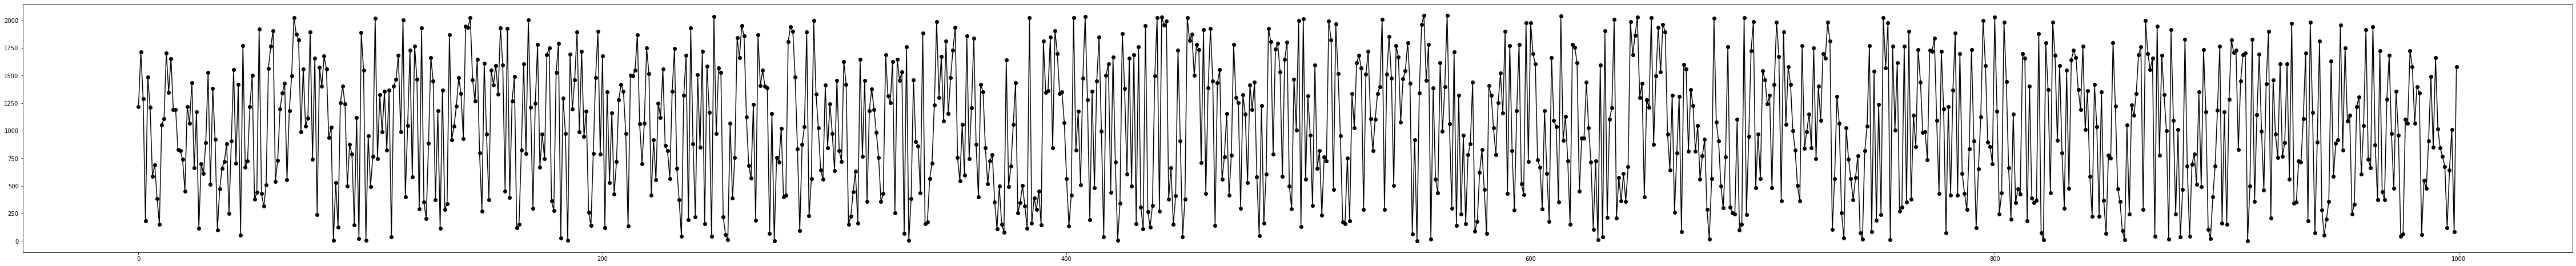

In [110]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],testing_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [168]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #encoded_message = numpy.round(encoded_message[0])
    encoded_message = encoded_message[0]
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    quntized_demodule_out = quntized_demodule_out[0]
    #quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.52s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.97s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.42s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.86s
SNR: 0.000:
 -> BER: 0.87
 -> Total Time: 4.77s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.44s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.89s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.37s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.82s
SNR: 0.500:
 -> BER: 0.85
 -> Total Time: 4.53s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.47s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.94s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.40s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.85s
SNR: 1.000:
 -> BER: 0.84
 -> Total Time: 4.67s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.44s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

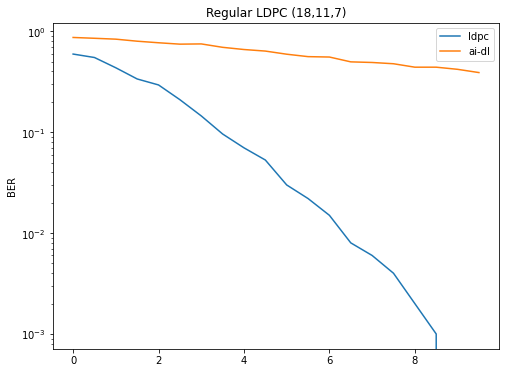

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [180]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.round(encoded_message[0])
    #encoded_message = encoded_message[0]
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    quntized_demodule_out = quntized_demodule_out[0]
    #quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.46s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.92s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.36s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.84s
SNR: 0.000:
 -> BER: 0.89
 -> Total Time: 4.58s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.45s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.91s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.36s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.82s
SNR: 0.500:
 -> BER: 0.87
 -> Total Time: 4.55s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.43s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.90s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.36s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.81s
SNR: 1.000:
 -> BER: 0.86
 -> Total Time: 4.50s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.45s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.92s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [181]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.round(encoded_message[0])
    #encoded_message = encoded_message[0]
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    #quntized_demodule_out = quntized_demodule_out[0]
    quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.47s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.95s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.41s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.87s
SNR: 0.000:
 -> BER: 0.97
 -> Total Time: 4.70s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.43s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.89s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.79s
SNR: 0.500:
 -> BER: 0.98
 -> Total Time: 4.44s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.48s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.94s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.38s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.83s
SNR: 1.000:
 -> BER: 0.98
 -> Total Time: 4.63s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.46s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.91s
SNR: 1.500 - Iter: 750 - Last 250.0 itera